In [19]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from src import load_dataset, build_model
import matplotlib.pyplot as plt

In [20]:
train_data, val_data = load_dataset()

Path to dataset files: /Users/myeoh/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# ----------------------------------------------------------------------
# Code adapted from PyTorch CIFAR-10 tutorial: 
# https://pytorch.org/tutorials/downloads/cifar10_tutorial.py
# ----------------------------------------------------------------------
net = build_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# helper function
def calculate_accuracy(data_loader, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

train_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    epoch_loss = running_loss / len(train_data)
    train_loss.append(epoch_loss)
    
    train_acc = calculate_accuracy(train_data, net)
    train_accuracy.append(train_acc)
    print(f'Accuracy on training set: {train_acc:.2f} %')

    test_acc = calculate_accuracy(val_data, net)
    test_accuracy.append(test_acc)
    print(f'Accuracy on test set: {test_acc:.2f} %')

print('Finished Training')

# Save model
project_root = os.path.dirname(os.getcwd())
os.makedirs(os.path.join(project_root, "models"), exist_ok=True)
save_path = os.path.join(project_root, "models", "emotion_net.pth")
torch.save(net.state_dict(), save_path)
print(f"Saved model to {save_path}")

[1,  2000] loss: 1.817
[1,  4000] loss: 1.727
[1,  6000] loss: 1.645
Accuracy on training set: 38.46 %
Accuracy on test set: 37.67 %
[2,  2000] loss: 1.559
[2,  4000] loss: 1.512
[2,  6000] loss: 1.483
Accuracy on training set: 44.34 %
Accuracy on test set: 42.53 %
[3,  2000] loss: 1.406
[3,  4000] loss: 1.397
[3,  6000] loss: 1.364
Accuracy on training set: 50.20 %
Accuracy on test set: 47.50 %
[4,  2000] loss: 1.287
[4,  4000] loss: 1.290
[4,  6000] loss: 1.278
Accuracy on training set: 55.11 %
Accuracy on test set: 48.98 %
[5,  2000] loss: 1.196
[5,  4000] loss: 1.183
[5,  6000] loss: 1.207
Accuracy on training set: 60.45 %
Accuracy on test set: 50.89 %
[6,  2000] loss: 1.081
[6,  4000] loss: 1.111
[6,  6000] loss: 1.132
Accuracy on training set: 65.19 %
Accuracy on test set: 51.81 %
[7,  2000] loss: 0.975
[7,  4000] loss: 1.024
[7,  6000] loss: 1.025
Accuracy on training set: 68.51 %
Accuracy on test set: 52.15 %
[8,  2000] loss: 0.872
[8,  4000] loss: 0.928
[8,  6000] loss: 0.944


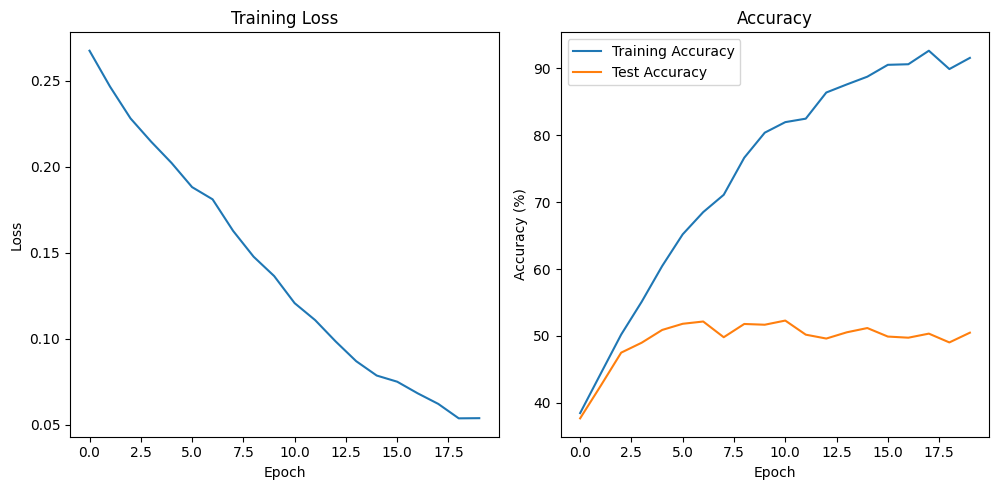

In [22]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()